<a href="https://colab.research.google.com/github/shahin1009/EDMD/blob/main/EDMDc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [272]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rcParams['figure.figsize'] = (5, 4)

In [273]:
# Unforced
def f(q, t):
    x, y = q
    return [y, x-x**3]


def forcing(t):
    return 2 * np.sin(2 * np.pi * 0.1 * t) * np.sin(2 * np.pi * 1 * t)

def ff(q, t):
    x, y = q
    return [y, x-x**3+forcing(t)] 

def solve(f , ic,t):
    sol = odeint(f, ic, t)
    return sol



In [274]:
t = np.linspace(0, 9.99, 1000)
dt=t[1]-t[0]
x0 = np.array([0, -2.8])
y=solve(f,x0,t)
yf = solve(ff,x0,t)
uf = forcing(t)

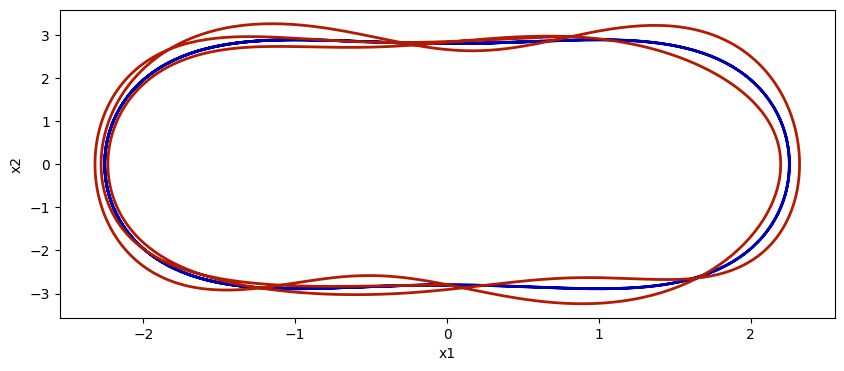

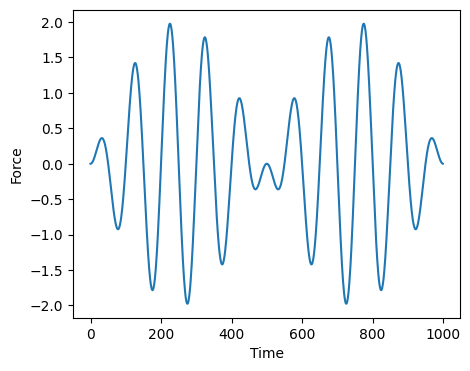

In [275]:
fig, ax1 = plt.subplots(figsize=(10, 4))  # Create a figure with two subplots

ax1.plot(y[:, 0], y[:, 1], '-', color=[0, 0, 0.7], linewidth=2)
ax1.plot(yf[:, 0], yf[:, 1], '-', color=[0.7, 0.1, 0], linewidth=2)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
plt.show()

fig3 = plt.figure()
plt.plot(uf)
plt.xlabel('Time')
plt.ylabel('Force')

plt.show()

In [276]:
def buildTheta(yin, nVars, polyorder):


    """
    Builds a polynomial dictionary from input data.

    Args:
        yin: Input data.
        nVars: Number of input variables.
        polyorder: Polynomial order.

    Returns:
        Polynomial dictionary.
    """
    n = yin.shape[0]
    ind = 0
    yout = np.zeros((n, nVars))

    # Copy input variables to output
    for i in np.arange(nVars):
        yout[:, ind] = yin[:, i]
        ind += 1


    if polyorder >= 2:
        # Polynomial order 2
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                new_col = yin[:, i] * yin[:, j]
                yout = np.append(yout, new_col.reshape(-1, 1), 1)
    

    if polyorder >= 3:
        # Polynomial order 3
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    new_col = yin[:, i] * yin[:, j] * yin[:, k]
                    yout = np.append(yout, new_col.reshape(-1, 1), 1)
           
    if polyorder >= 4:
        # Polynomial order 4
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    for l in np.arange(k, nVars):
                        new_col = yin[:, i] * yin[:, j] * yin[:, k] * yin[:, l]
                        yout = np.append(yout, new_col.reshape(-1, 1), 1)
             


    return yout

In [277]:
yf

array([[ 0.        , -2.8       ],
       [-0.02800047, -2.80013727],
       [-0.05600362, -2.80053812],
       ...,
       [ 0.75866727,  2.9614372 ],
       [ 0.78829765,  2.96459258],
       [ 0.81795817,  2.96746021]])

In [278]:
polyorder = 4
nvar = 2

Theta = buildTheta(yf, nvar, polyorder)
Theta = Theta.T

Nstates = Theta.shape[0]
print(Nstates)
G = np.append(Theta[:,:-1], uf[:-1].reshape(1, -1), 0)


14


In [279]:
from scipy.linalg import svd , inv

Ug, Sg, Vg = svd(G, full_matrices=False)
print(Vg.shape)
print(Theta[:,1:].shape)
AB = Theta[:,1:] @ Vg.T @ inv(np.diag(Sg[:15])) @ Ug.T
Am = AB[:Nstates, :Nstates]
Bm = np.array(AB[:Nstates, -1]).reshape(-1,1)
Cm = np.eye(Nstates)
Dm = np.zeros((Nstates, 1))
Bm

(15, 999)
(14, 999)


array([[ 5.00016922e-05],
       [ 9.99855822e-03],
       [ 4.76190695e-05],
       [ 4.74108185e-03],
       [-7.61941015e-03],
       [ 3.83624981e-04],
       [ 2.55642431e-02],
       [-6.85232355e-04],
       [ 1.85313566e-01],
       [ 4.19198279e-04],
       [ 2.07895648e-02],
       [-1.89591636e-02],
       [ 3.68576201e-02],
       [-5.71611782e-02]])

In [280]:
!pip install control

# yEDMDc = lsim(sysmodel_EDMDc, uF.T, tspan, X0=poolData(x0, 2, pEDMDc.polyorder, pEDMDc.usesine).T)[0]
# yEDMDc = yEDMDc[:, :2]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [281]:
 from control.matlab import *
 
 sysmodel_EDMDc = ss(Am,Bm,Cm,Dm,0.01)

In [296]:
yEDMDc, T, xout = lsim(sysmodel_EDMDc,uf,t,buildTheta(x0.reshape(1,-1),nvar, polyorder).T)

In [297]:
yEDMDc.shape

(1000, 14)

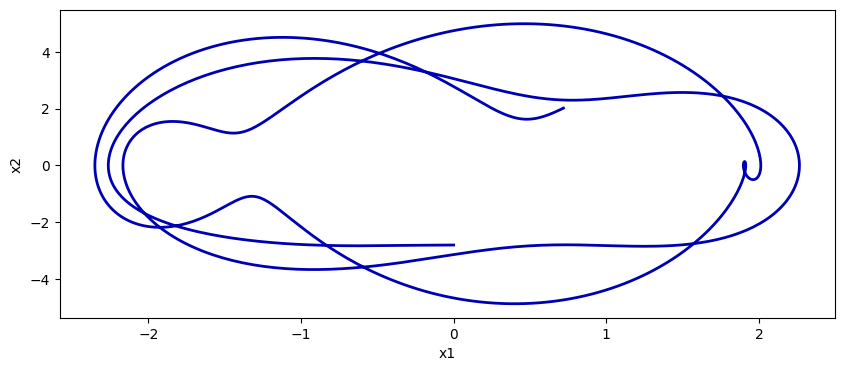

In [298]:
fig, ax1 = plt.subplots(figsize=(10, 4))  # Create a figure with two subplots

ax1.plot(yEDMDc[:, 0], yEDMDc[:, 1], '-', color=[0, 0, 0.7], linewidth=2)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
plt.show()